## import

In [18]:
seed = 42

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import statistics
from sklearn.decomposition import PCA

import pickle

## caricamento dati

### caricamento labels pazienti

In [19]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]


### caricamento features encoder

In [20]:

file_path = "../CSV/VGG19_Slice_Maggiore.csv"
df = pd.read_csv(file_path, sep=',')


df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)

df_ordered = df.set_index('Unnamed: 0').loc[loaded_patients].reset_index()

df_features = df_ordered.drop(columns=['Unnamed: 0'])

features = df_features.to_numpy()

print(features)
print(features.shape)


[[ 10.644694  42.666046   0.       ...   0.        18.299337   6.166822]
 [  0.       102.23023    0.       ...  18.42938   31.46421    0.      ]
 [  0.946728  28.357668   0.       ...   0.        18.290043   9.094667]
 ...
 [ 11.950816  10.536694  14.736543 ...   0.        27.75255   13.213755]
 [  0.       161.865      0.       ...   0.        19.546183  16.224407]
 [  0.       129.88449    0.       ...   0.        48.395874  11.344899]]
(129, 512)


## funzioni varie 

In [21]:

## Rimozione feature correlation
def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    X_reduced = np.delete(X, to_drop, axis=1)
    return X_reduced, to_drop

## Rimozione features p_value
def remove_high_pvalue_features(X, y, alpha=0.05):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    p_values = selector.pvalues_
    features_to_keep = np.where(p_values < alpha)[0]
    X_reduced = X[:, features_to_keep]
    return X_reduced, features_to_keep

## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def select_features_by_p_value(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected


## funzioni di classificazione

In [22]:
## classificazione completa che ritorna la threshold migliore per la classificazione
def classification_method(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0], thresholds=np.arange(0.4, 0.6, 0.01)):
    best_f1_score = 0
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    if(isinstance(thresholds, np.ndarray)== False): ## se la threshold viene data fissa
        thresholds=[thresholds]
        
    
    for threshold in thresholds:

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)

            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            conf = confusion_matrix(y_test, y_pred_custom_test)

            # Se il nuovo risultato è migliore rispetto al migliore attuale (in base all'f1 e altrimenti pr_auc)
            if f1 > best_f1_score or (f1 == best_f1_score and pr_auc > (best_case['pr_auc'] if best_case else 0)):
                best_f1_score = f1
                best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': threshold
                }

    return best_case


#####################################################################################################################################

### questo ritorna le il vettore di probabilità senza fare la classificazione
def classification_method_withoutThreshold(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0]):

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if (len(selected_features)==0):
                    return [0],0,[0]
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

 
    return y_proba_test, number_features, selected_features


#####################################################################################################################################


### classificazione effettuata con una threshold specifica
def classification_threshold(y_proba_test,y_test, threshold, alpha, number_features, selected_features):
        
            best_case = None

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)
            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            conf = confusion_matrix(y_test, y_pred_custom_test)
            best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'threshold': threshold
                }
                
            if not best_case:
                 print("Attenzione caso vuoto") 
            return best_case

#####################################################################################################################################


# metodo che definisce la threshold ottimale attraverso Youden's J statistic (threshold_selection= 'y')
# oppure attraverso la distanza euclidea dalla curva ROC (threshold_selection= 'd')
def classification_method_selection(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, threshold_selection, mode="Val", selected_features=[0]):
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba_test)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)
        
    fpr,tpr,threshold=roc_curve(y_test,y_proba_test,pos_label=1)
    youden_j = tpr - fpr
    optimal_threshold = threshold[np.argmax(youden_j)]

    ## due modalità 
    if threshold_selection == 'y':
        youden_j = tpr - fpr
        optimal_threshold = threshold[np.argmax(youden_j)]
    elif threshold_selection == 'd':
        distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
        optimal_threshold = threshold[np.argmin(distances)]
    else:
        print('Threshold non valida!')
        return None

    
    y_pred_custom_test = (y_proba_test >= optimal_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    conf = confusion_matrix(y_test, y_pred_custom_test)


    best_case = {
        'alpha': alpha,
        'num_features': number_features,
        'selected_features': selected_features,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': optimal_threshold,
        'threshold_mode': threshold_selection
    }

    return best_case


## split

In [23]:
Y_train, y_test, X_train, X_test= train_test_split(labels, features, test_size=0.3, shuffle=False, random_state=1)

## correlation e p_value

In [24]:


## NORMALIZZAZIONE

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## FEATURE CORRELATION

X_train_reduced, dropped_features = remove_highly_correlated_features(X_train_scaled, 0.8)
#X_val_reduced = np.delete(X_val, dropped_features, axis=1)
X_test_reduced = np.delete(X_test_scaled, dropped_features, axis=1)

print(X_train_reduced.shape)
#print(X_test_reduced.shape)
#print(X_val_reduced.shape)

# RIMOZIONE FEATURES CON P_VALUE ELEVATO

X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train_reduced, Y_train, alpha=0.05)
#X_val_reduced = X_val_reduced[:, features_to_keep]
X_test_reduced = X_test_reduced[:, features_to_keep]
print(X_train_reduced.shape)

## RIDUZIONE DELLA DIMENSIONALITA CON PCA

pca = PCA(n_components=9)  # Tengo 25 componenti
#X_train_reduced = pca.fit_transform(X_train_reduced)
#X_test_reduced = pca.transform(X_test_reduced)
#print(sum(pca.explained_variance_ratio_))

print(X_train_reduced.shape)
print(X_test_reduced.shape)


(90, 491)
(90, 133)
(90, 133)
(39, 133)


## parametri

In [25]:


alpha_1 = np.linspace(0, 0.25, 40).tolist() ## questo è il range per la radiomica - con vgg a 2.5 non ne trova piu nessuna

#alpha_2 = np.linspace(0, 0.005, 21).tolist()

alpha_values=alpha_1 
#alpha_values.remove(0.0)


#thresholds=np.arange(0.4, 0.61, 0.01) 

thresholds=[0.5]

selectors=['lasso','p_value', 'mrmr','rf', 'logistic']

classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']


# METODO 2 - threshold tuning con val
Attraverso gridsearch sui risultati delle performance medie ottenute dalla cross validation trova la migliore combinazione tra classifier, selector, num_features (o alpha) e threshold. poi applica questa configurazione al test
scelgo la configurazione migliore attraverso f1

### Dati sintetici

In [210]:
from ctgan import CTGAN
from scipy.special import rel_entr
import torch


def generate_synthetic_data_ctgan_with_kl(X, y, n_samples, categorical_columns=None, random_state=42):
    """
    Genera dati sintetici usando CTGAN e calcola la divergenza KL per ogni feature.
    
    Args:
    - X: Lista di vettori di features per ogni paziente (array di array).
    - y: Vettore di etichette binarie per ogni paziente.
    - n_samples: Numero di campioni sintetici da generare.
    - categorical_columns: Lista di indici delle colonne categoriche (se presenti).
    
    Returns:
    - X_augmented: Array contenente X originale con aggiunti i campioni sintetici.
    - y_augmented: Array contenente y originale con aggiunte le etichette sintetiche.
    - kl_divergences: Lista delle divergenze di Kullback-Leibler tra le distribuzioni delle features.
    """
    
    np.random.seed(random_state)
    torch.manual_seed(50)
    
    # Assicurati che X e y siano convertiti in formato float64
    X = np.array(X).astype(np.float64)
    y = np.array(y).astype(np.float64)
    
    # Combina X e y in un unico array NumPy
    data = np.column_stack((X, y))
    
    # Converti in DataFrame per CTGAN, e aggiungi la colonna 'target'
    column_names = [f"feature_{i}" for i in range(X.shape[1])] + ['target']
    data_df = pd.DataFrame(data, columns=column_names)
    
    # Imposta la colonna 'target' come categorica
    if categorical_columns is None:
        categorical_columns = ['target']

    # Inizializza il modello CTGAN
    ctgan = CTGAN(epochs=500, batch_size=20, discriminator_lr=1e-4,generator_lr=1e-4)
    
    # Allena il modello sui dati
    ctgan.fit(data_df, categorical_columns)
    
    # Genera nuovi campioni sintetici
    synthetic_data = ctgan.sample(n_samples)
    
    # Estrai le etichette sintetiche e le features sintetiche
    y_synthetic = synthetic_data['target'].values
    X_synthetic = synthetic_data.drop('target', axis=1).values
    
    # Combina i dati originali con quelli sintetici
    X_augmented = np.vstack((X, X_synthetic))
    y_augmented = np.hstack((y, y_synthetic))

    # Mescola i dati e le etichette
    indices = np.random.permutation(X_augmented.shape[0])
    X_augmented = X_augmented[indices]
    y_augmented = y_augmented[indices]
    
    # Calcola la divergenza KL tra le distribuzioni delle features originali e sintetiche
    kl_divergences = []
    
    smoothing=1e-6

    bin_number =int(np.ceil(np.log2(X.shape[0]) + 1))

    for i in range(X.shape[1]):
        # Crea istogrammi normalizzati delle features reali e sintetiche
        real_hist, bin_edges = np.histogram(X[:, i], bins=bin_number, density=True)  # Riduci i bin
        synthetic_hist, _ = np.histogram(X_synthetic[:, i], bins=bin_edges, density=True)
        
        # Normalizza gli istogrammi per ottenere distribuzioni di probabilità
        real_hist = real_hist + smoothing
        synthetic_hist = synthetic_hist + smoothing

        real_hist = real_hist / np.sum(real_hist)
        synthetic_hist = synthetic_hist / np.sum(synthetic_hist)
        
        # Calcola la divergenza KL usando la funzione rel_entr
        kl_div = np.sum(rel_entr(real_hist, synthetic_hist))
        kl_divergences.append(kl_div)
    
    plot_kl_divergences(kl_divergences)
    
    return X_augmented, y_augmented

def plot_kl_divergences(kl_divergences):
    """
    Crea un grafico a barre per visualizzare le divergenze KL per ciascuna feature.
    
    Args:
    - kl_divergences: Lista delle divergenze KL per ciascuna feature.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(kl_divergences)), kl_divergences, color='skyblue')
    plt.xlabel('Feature Index')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence between Real and Synthetic Data for Each Feature')
    plt.xticks(range(len(kl_divergences)), range(len(kl_divergences)))
    plt.show()


## Loop per Validation

In [26]:
n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)


template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'threshold': None,
                'selected_features': [],
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val_2_others = [template_dict.copy() for _ in range(300000)]
results_val_2_others.append(template_dict.copy())

results_val_2_lasso = [template_dict.copy() for _ in range(300000)]
results_val_2_lasso.append(template_dict.copy())

smote = SMOTE()

k=0
old_count = 0
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    #zero_count = np.sum(y_train_red == 0)
    #one_count = np.sum(y_train_red == 1)

    #print(f"Numero di 0 nel train: {zero_count}")
    #print(f"Numero di 1 nel train: {one_count}")

    ## SMOTE
    #x_train_reduced, y_train = smote.fit_resample(x_train_red, y_train_red)

    ## DATI SINTETICI
    #x_train_reduced, y_train = generate_synthetic_data_ctgan_with_kl(x_train_red, y_train_red, 200)

    #print(y_train)
    #zero_count = np.sum(y_train == 0)
    #one_count = np.sum(y_train == 1)

    #print(f"Numero di 0 nel train: {zero_count}")
    #print(f"Numero di 1 nel train: {one_count}")

    for i, classifier in enumerate(classifiers):
        print("Starting with classifier:", classifier)
        for j, selector in enumerate(selectors):
            #print("Starting with selector:", selector)

            if(selector=='lasso'):
                selected_features_temp= []

                for alpha in alpha_values:
                    #print("alpha: ", alpha)
                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                    elif classifier == 'Logistic':
                        classi = LogisticRegression(random_state=42)
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier(random_state=42)
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    y_proba_test, number_features, selected_features = classification_method_withoutThreshold(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, num_features=0, mode="Val", selected_features=[0])
                    if (np.array_equal(y_proba_test,[0]) and  number_features==0 and np.array_equal(selected_features,[0])):
                        continue

                    #found=False
                    #for vec in selected_features_temp:
                    #   if np.array_equal(selected_features, vec):
                    #       found=True
                    #if found==True:
                    #   continue

                    fpr_val, tpr_val, roc_thresholds_val = roc_curve(y_val, y_proba_test)

                    # Calcola il ROC AUC
                    roc_auc_val = roc_auc_score(y_val, y_proba_test)
                    precision, recall, _ = precision_recall_curve(y_val, y_proba_test)
                    pr_auc = auc(recall, precision)

                    best_case_val = None

                    # Itera su tutte le soglie e salva i risultati per ognuna
                    for threshold in thresholds:
                        best_case_val = classification_threshold(y_proba_test, y_val, threshold, alpha, number_features, selected_features)
                        
                        if best_case_val:
                            results_val_2_lasso[k] = {
                                        'fold': fold_idx,
                                        'classifier': classifier,
                                        'selector': selector,
                                        'alpha': alpha,
                                        'num_features': number_features,
                                        'selected_features': best_case_val['selected_features'],
                                        'pr_auc': pr_auc,
                                        'roc_auc': roc_auc_val,
                                        'f1': best_case_val['f1'],
                                        'accuracy': best_case_val['accuracy'],
                                        'confusion_matrix': best_case_val['confusion_matrix'],
                                        'threshold': threshold,

                            }

                            k = k + 1

            else:

                #limit=len(x_train_reduced[0]) + 1
                limit=30
                for t in range(1, limit):
                        #print("Number of features ", t)

                        if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42)
                        elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
                        elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
                        elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                        elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )

                    
                        y_proba_test, number_features, selected_features = classification_method_withoutThreshold(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, num_features=t, mode="Val", selected_features=[0])

                        fpr_val, tpr_val, roc_thresholds_val = roc_curve(y_val, y_proba_test)
    
                        # Calcola il ROC AUC
                        roc_auc_val = roc_auc_score(y_val, y_proba_test)
                        precision, recall, _ = precision_recall_curve(y_val, y_proba_test)
                        pr_auc = auc(recall, precision)

                        # Variabili per tenere traccia del miglior F1 score e threshold sul validation
                        best_f1_val = -1
                        best_threshold_val = 0
                        best_case_val = None
                        
                        # Itera su tutte le soglie e salva i risultati per ognuna
                        for threshold in thresholds:
            
                            best_case_val = classification_threshold(y_proba_test, y_val, threshold, 0, t, selected_features)
                                
                            if best_case_val:
                                results_val_2_others[k] = {
                                    'fold': fold_idx,
                                    'classifier': classifier,
                                    'selector': selector,
                                    'alpha': 0,
                                    'num_features': t,
                                    'selected_features': best_case_val['selected_features'],
                                    'pr_auc': pr_auc,
                                    'roc_auc': roc_auc_val,
                                    'f1': best_case_val['f1'],
                                    'accuracy': best_case_val['accuracy'],
                                    'confusion_matrix': best_case_val['confusion_matrix'],
                                    'threshold': threshold, 
                                }
                                k = k + 1
                            else:
                                print("sono vuoto")

Starting with fold: 0
Starting with classifier: XgBoost
Starting with classifier: SVM
Starting with classifier: ensemble
Starting with classifier: RandomForest
Starting with classifier: Logistic
Starting with classifier: MLP
Starting with fold: 1
Starting with classifier: XgBoost
Starting with classifier: SVM
Starting with classifier: ensemble
Starting with classifier: RandomForest
Starting with classifier: Logistic
Starting with classifier: MLP
Starting with fold: 2
Starting with classifier: XgBoost
Starting with classifier: SVM
Starting with classifier: ensemble
Starting with classifier: RandomForest
Starting with classifier: Logistic
Starting with classifier: MLP
Starting with fold: 3
Starting with classifier: XgBoost
Starting with classifier: SVM
Starting with classifier: ensemble
Starting with classifier: RandomForest
Starting with classifier: Logistic
Starting with classifier: MLP
Starting with fold: 4
Starting with classifier: XgBoost
Starting with classifier: SVM
Starting with 

## Loop per test

In [27]:

template_dict = {
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'threshold': None,
                'selected_features': [],
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_test_2_others = [template_dict.copy() for _ in range(300000)]
results_test_2_others.append(template_dict.copy())

results_test_2_lasso = [template_dict.copy() for _ in range(300000)]
results_test_2_lasso.append(template_dict.copy())

smote = SMOTE()

k=0
old_count = 0

for i, classifier in enumerate(classifiers):
        print("Starting with classifier:", classifier)
        for j, selector in enumerate(selectors):
            #print("Starting with selector:", selector)

            if(selector=='lasso'):
                selected_features_temp= []

                for alpha in alpha_values:
                    #print("alpha: ", alpha)
                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                    elif classifier == 'Logistic':
                        classi = LogisticRegression(random_state=42)
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier(random_state=42)
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    y_proba_test, number_features, selected_features = classification_method_withoutThreshold(selector, classi, alpha, X_train_reduced, Y_train, X_test_reduced, y_test, num_features=0, mode="Val", selected_features=[0])
                    if (np.array_equal(y_proba_test,[0]) and  number_features==0 and np.array_equal(selected_features,[0])):
                        continue

                    #found=False
                    #for vec in selected_features_temp:
                    #   if np.array_equal(selected_features, vec):
                    #       found=True
                    #if found==True:
                    #   continue

                    fpr_val, tpr_val, roc_thresholds_val = roc_curve(y_test, y_proba_test)

                    # Calcola il ROC AUC
                    roc_auc_val = roc_auc_score(y_test, y_proba_test)
                    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
                    pr_auc = auc(recall, precision)

                    best_case_val = None

                    # Itera su tutte le soglie e salva i risultati per ognuna
                    for threshold in thresholds:
                        best_case_val = classification_threshold(y_proba_test, y_test, threshold, alpha, number_features, selected_features)
                        
                        if best_case_val:
                            results_test_2_lasso[k] = {
                                        'classifier': classifier,
                                        'selector': selector,
                                        'alpha': alpha,
                                        'num_features': number_features,
                                        'selected_features': best_case_val['selected_features'],
                                        'pr_auc': pr_auc,
                                        'roc_auc': roc_auc_val,
                                        'f1': best_case_val['f1'],
                                        'accuracy': best_case_val['accuracy'],
                                        'confusion_matrix': best_case_val['confusion_matrix'],
                                        'threshold': threshold
                                    }
    

                            k = k + 1

            else:

                #limit=len(x_train_reduced[0]) + 1
                limit=30
                for t in range(1, limit):
                        #print("Number of features ", t)

                        if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42)
                        elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
                        elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
                        elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                        elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )

                    
                        y_proba_test, number_features, selected_features = classification_method_withoutThreshold(selector, classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, num_features=t, mode="Val", selected_features=[0])

                        fpr_val, tpr_val, roc_thresholds_val = roc_curve(y_test, y_proba_test)
    
                        # Calcola il ROC AUC
                        roc_auc_val = roc_auc_score(y_test, y_proba_test)
                        precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
                        pr_auc = auc(recall, precision)

                        # Variabili per tenere traccia del miglior F1 score e threshold sul validation
                        best_f1_val = -1
                        best_threshold_val = 0
                        best_case_val = None
                        
                        # Itera su tutte le soglie e salva i risultati per ognuna
                        for threshold in thresholds:
            
                            best_case_val = classification_threshold(y_proba_test, y_test, threshold, 0, t, selected_features)
                                
                            if best_case_val:
                                results_test_2_others[k] = {
                                    'classifier': classifier,
                                    'selector': selector,
                                    'alpha': 0,
                                    'num_features': t,
                                    'selected_features': best_case_val['selected_features'],
                                    'pr_auc': pr_auc,
                                    'roc_auc': roc_auc_val,
                                    'f1': best_case_val['f1'],
                                    'accuracy': best_case_val['accuracy'],
                                    'confusion_matrix': best_case_val['confusion_matrix'],
                                    'threshold': threshold, 
                                }
                                k = k + 1

Starting with classifier: XgBoost
Starting with classifier: SVM
Starting with classifier: ensemble
Starting with classifier: RandomForest
Starting with classifier: Logistic
Starting with classifier: MLP


## Sorting the results
gridsearch per classificatore, selector, num_features (alpha) e threshold
ordinati per f1 e se parità threshold auc

In [46]:
num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))
num_features_range=list(range(1,30))

grid_results_others = {}
grid_results_lasso = {}

selectors_other = ['mrmr', 'rf', 'logistic', 'p_value']

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors_other:
            #print(f"Sto iniziando selector {selector}")
            for num_features in num_features_range:
                for threshold in thresholds:
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results=[]
                    for res in results_val_2_others:
                        ## qui filtro per num_features
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features):
                            filtered_results.append(res)
                
                    if filtered_results:
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]
                        roc_auc_values = [res['roc_auc'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                        avg_roc_auc = sum(roc_auc_values) / len(roc_auc_values)

                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_auc_values) if len(roc_auc_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_others[(classifier, selector, num_features)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy,
                            'avg_roc_auc': avg_roc_auc,
                            'std_roc_auc': std_roc_auc,
                        }



## ORA PER LASSO
selector_lasso = ['lasso']
print(f"Sto iniziando selector {selector_lasso[0]}")
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selector_lasso:
        for alpha in alpha_values:
            for threshold in thresholds:
                filtered_results = []
                for res in results_val_2_lasso:
                    ## qui filtro per alpha
                    if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha):
                        filtered_results.append(res)

                if filtered_results:
                    pr_auc_values = [res['pr_auc'] for res in filtered_results]
                    f1_values = [res['f1'] for res in filtered_results]
                    accuracy_values = [res['accuracy'] for res in filtered_results]
                    roc_auc_values = [res['roc_auc'] for res in filtered_results]

        
                    avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                    avg_f1 = sum(f1_values) / len(f1_values)
                    avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                    avg_roc_auc = sum(roc_auc_values) / len(roc_auc_values)

         
                    std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                    std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                    std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                    std_roc_auc = statistics.stdev(roc_auc_values) if len(roc_auc_values) > 1 else 0

                    grid_results_lasso[(classifier, selector, alpha)] = {
                        'avg_pr_auc': avg_pr_auc,
                        'std_pr_auc': std_pr_auc,
                        'avg_f1': avg_f1,
                        'std_f1': std_f1,
                        'avg_accuracy': avg_accuracy,
                        'std_accuracy': std_accuracy,
                        'avg_roc_auc': avg_roc_auc,
                        'std_roc_auc': std_roc_auc,
                    }

# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)

# Combina i risultati di entrambi i grid search
sorted_results_2 = sorted_results_others + sorted_results_lasso
sorted_results_2 = sorted(sorted_results_2, key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)

Sto iniziando classifier XgBoost
Sto iniziando classifier SVM
Sto iniziando classifier ensemble
Sto iniziando classifier RandomForest
Sto iniziando classifier Logistic
Sto iniziando classifier MLP
Sto iniziando selector lasso
Sto iniziando classifier XgBoost
Sto iniziando classifier SVM
Sto iniziando classifier ensemble
Sto iniziando classifier RandomForest
Sto iniziando classifier Logistic
Sto iniziando classifier MLP


## applico al test le migliori n configurazioni trovate

In [48]:
n=40
best_combinations = sorted_results_2[:n] ## mostrando le n migliori configurazioni

print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):

    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")
    #print(f"Threshold: {params[3]}")

    print(f"Performance medie sul val set: \nF1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "f"ROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")



    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression(random_state=42)
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)],
                                voting='soft')

   
    if(params[1]=='lasso'):     
        best_case=classification_method(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=0.5)
    else: 
        best_case=classification_method(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=0.5)


    print("Metrics on the TEST set:")
        
    if(best_case==0):
            print("found 0 features")
            continue
    if (params[1]=='lasso'):
                    print(f"Alpha: {best_case['alpha']}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {best_case['best_threshold']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


Migliori 40 combinazioni di parametri:

#1:
Classifier: MLP
Selector: logistic
Num_features: 11
Performance medie sul val set: 
F1 = 0.0 (std = 0.0), PR AUC = 0.7178641574474909 (std = 0.14798030620480984), ROC AUC = 0.7955246913580247 (std = 0.09940907172961115), Accuracy = 0.5444444444444445 (std = 0.024845199749997673)
Metrics on the TEST set:
Number of Features: 11
Threshold: 0.5
Selected Features: [44 28 47 93 65 26 35 72 33 40 54]
Precision-Recall AUC: 0.30322694304840564
ROC AUC: 0.5216049382716049
F1 Score: 0.0
Accuracy: 0.6923076923076923
Confusion Matrix: 
[[27  0]
 [12  0]]

#2:
Classifier: SVM
Selector: lasso
Alpha: 0.019230769230769232
Performance medie sul val set: 
F1 = 0.6458090928679164 (std = 0.13703692408391352), PR AUC = 0.7301027332553068 (std = 0.06414145977302493), ROC AUC = 0.7854938271604939 (std = 0.052031123809127174), Accuracy = 0.711111111111111 (std = 0.08240220541217404)
Metrics on the TEST set:
Alpha: 0.019230769230769232
Number of Features: 30
Threshold

In [37]:
import pandas as pd
import statistics

# Assuming you already have the combined results lists
# results_test_2_others and results_test_2_lasso

# Combine results_test_2_others and results_test_2_lasso
combined_results = results_test_2_others + results_test_2_lasso

# Convert the list of dictionaries into a DataFrame for easier sorting and handling
df_combined = pd.DataFrame(combined_results)

# Sort by roc_auc in descending order
df_sorted = df_combined.sort_values(by='pr_auc', ascending=False)

# Select the top 10 results
top_10_results = df_sorted.head(10)

# For each result in top_10_results, find the corresponding validation averages from sorted_results_2

# Display the top 10 cases with relevant metrics and their validation averages
for i, row in top_10_results.iterrows():
    classifier = row['classifier']
    selector = row['selector']
    num_features = row['num_features'] if selector != 'lasso' else row['alpha']
    
    # Find the matching validation results from sorted_results_2
    matching_val_result = None
    for res in sorted_results_2:
        if selector == 'lasso':
            if res[0] == (classifier, selector, row['alpha']):
                matching_val_result = res
                break
        else:
            if res[0] == (classifier, selector, row['num_features']):
                matching_val_result = res
                break
    
    # If there's a match, print both test and validation metrics
    print(f"Case {i+1}:")
    print(f"Classifier: {row['classifier']}")
    print(f"Selector: {row['selector']}")
    if row['selector'] == 'lasso':
        print(f"Alpha: {row['alpha']}")
    else:
        print(f"Num Features: {row['num_features']}")
    print(f"F1 Score (Test): {row['f1']}")
    print(f"ROC AUC (Test): {row['roc_auc']}")
    print(f"PR AUC (Test): {row['pr_auc']}")
    print(f"Accuracy (Test): {row['accuracy']}")
    print(f"Confusion Matrix (Test): \n{row['confusion_matrix']}")
    
    if matching_val_result:
        print("\nValidation Metrics (Averages):")
        print(f"Avg F1: {matching_val_result[1]['avg_f1']}")
        print(f"Avg ROC AUC: {matching_val_result[1]['avg_roc_auc']}")
        print(f"Avg PR AUC: {matching_val_result[1]['avg_pr_auc']}")
        print(f"Avg Accuracy: {matching_val_result[1]['avg_accuracy']}")
        print(f"Std F1: {matching_val_result[1]['std_f1']}")
        print(f"Std ROC AUC: {matching_val_result[1]['std_roc_auc']}")
        print(f"Std PR AUC: {matching_val_result[1]['std_pr_auc']}")
        print(f"Std Accuracy: {matching_val_result[1]['std_accuracy']}")
    else:
        print("\nNo matching validation results found.")
    
    print("="*50 + "\n")


Case 214:
Classifier: SVM
Selector: mrmr
Num Features: 7.0
F1 Score (Test): 0.625
ROC AUC (Test): 0.79320987654321
PR AUC (Test): 0.6926168650642944
Accuracy (Test): 0.6923076923076923
Confusion Matrix (Test): 
[[17 10]
 [ 2 10]]

Validation Metrics (Averages):
Avg F1: 0.6238763575605681
Avg ROC AUC: 0.6779629629629629
Avg PR AUC: 0.6002394089434531
Avg Accuracy: 0.6555555555555556
Std F1: 0.12524083675833766
Std ROC AUC: 0.17752942481043915
Std PR AUC: 0.19373887142886995
Std Accuracy: 0.10686324478706302

Case 212:
Classifier: SVM
Selector: mrmr
Num Features: 5.0
F1 Score (Test): 0.6206896551724138
ROC AUC (Test): 0.7376543209876543
PR AUC (Test): 0.6867083157137338
Accuracy (Test): 0.717948717948718
Confusion Matrix (Test): 
[[19  8]
 [ 3  9]]

Validation Metrics (Averages):
Avg F1: 0.485
Avg ROC AUC: 0.7032098765432099
Avg PR AUC: 0.6452525157304568
Avg Accuracy: 0.6111111111111112
Std F1: 0.27540374402361023
Std ROC AUC: 0.10885031711994797
Std PR AUC: 0.06582257833390762
Std Accu

### Stampa delle sole migliori combinazioni classifier + selector

In [214]:
best_combinations = sorted_results_2  # mostrando le n migliori configurazioni

# Set per tenere traccia delle combinazioni già incontrate
seen_combinations = set()

print(f"Migliori combinazioni uniche di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):
    # Crea una tupla con classifier e selector per controllare la combinazione
    combination = (params[0], params[1])

    # Se la combinazione è già stata vista, la saltiamo
    if combination in seen_combinations:
        continue

    # Aggiungiamo la combinazione al set di quelle già viste
    seen_combinations.add(combination)

    # Stampiamo la combinazione e le metriche associate
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    
    if params[1] == 'lasso':
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")
    print(f"Threshold: {params[3]}")

    print(f"Performance medie sul val set: \nF1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), " 
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")

    # Inizializza il classificatore
    if params[0] == 'RandomForest':
        classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
        classi = LogisticRegression(random_state=42)
    elif params[0] == 'SVM':
        classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
        classi = XGBClassifier(random_state=42)
    elif params[0] == 'MLP':
        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
    elif params[0] == 'ensemble':
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        logistic_model = LogisticRegression(random_state=42)
        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
        classi = VotingClassifier(
            estimators=[
                ('random_forest', rf_model),
                ('logistic', logistic_model),
                ('svc', svc_model)
            ],
            voting='soft'
        )

    # Eseguiamo il metodo di classificazione
    if params[1] == 'lasso':
        best_case = classification_method(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=params[3])
    else:
        best_case = classification_method(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=params[3])

    # Stampa le metriche sul test set
    print("Metrics on the TEST set:")
    if best_case == 0:
        print("Found 0 features")
        continue

    if params[1] == 'lasso':
        print(f"Alpha: {best_case['alpha']}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {best_case['best_threshold']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")

Migliori combinazioni uniche di parametri:

#1:
Classifier: RandomForest
Selector: mrmr
Num_features: 18
Threshold: 0.44000000000000006
Performance medie sul val set: 
F1 = 0.7450653594771242 (std = 0.08316499080032555), PR AUC = 0.7243091505897878 (std = 0.1706842755200232), Accuracy = 0.7444444444444444 (std = 0.09296222517045283)
Metrics on the TEST set:
Number of Features: 18
Threshold: 0.44000000000000006
Selected Features: [4, 13, 12, 6, 2, 7, 15, 17, 9, 0, 8, 18, 16, 11, 5, 10, 1, 3]
Precision-Recall AUC: 0.3757747854227163
ROC AUC: 0.6219135802469136
F1 Score: 0.4375
Accuracy: 0.5384615384615384
Confusion Matrix: 
[[14 13]
 [ 5  7]]

#5:
Classifier: RandomForest
Selector: p_value
Num_features: 13
Threshold: 0.4
Performance medie sul val set: 
F1 = 0.7367801857585138 (std = 0.09369159719518096), PR AUC = 0.7833652519865756 (std = 0.12542079723055435), Accuracy = 0.7222222222222222 (std = 0.11785113019775793)
Metrics on the TEST set:
Number of Features: 13
Threshold: 0.4
Selected

## grafici

In [49]:
## classificazione completa che ritorna la threshold migliore per la classificazione
def classification_method_new(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0], thresholds=np.arange(0.4, 0.6, 0.01)):
    best_f1_score = 0
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    if(isinstance(thresholds, np.ndarray)== False): ## se la threshold viene data fissa
        thresholds=[thresholds]
        
    
    for threshold in thresholds:

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)

            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)
            fpr, tpr, _ = roc_curve(y_test, y_proba_test)
            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            conf = confusion_matrix(y_test, y_pred_custom_test)

            # Se il nuovo risultato è migliore rispetto al migliore attuale (in base all'f1 e altrimenti pr_auc)
            if f1 > best_f1_score or (f1 == best_f1_score and pr_auc > (best_case['pr_auc'] if best_case else 0)):
                best_f1_score = f1
                best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': threshold
                }

    return best_case, fpr, tpr

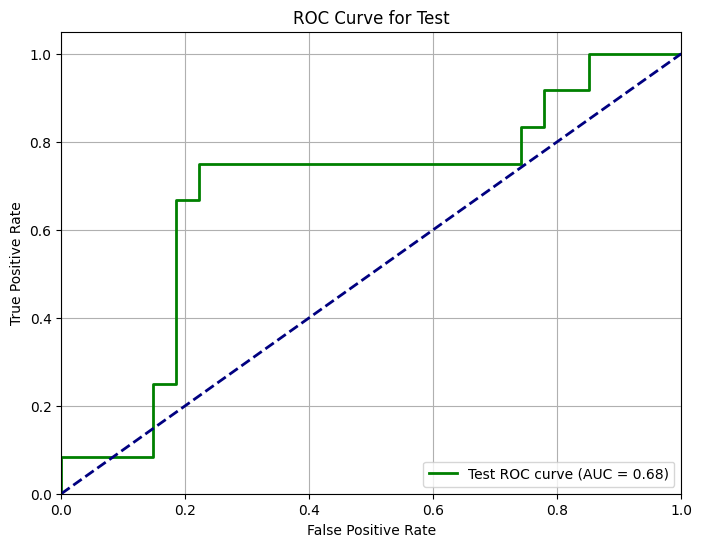

In [52]:
classi = SVC(kernel='rbf', probability=True, random_state=42)

best_case={}
best_case, fpr_test, tpr_test= classification_method_new('lasso', classi, 0.00641025641025641, X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=0.5)



# Assuming you already have the FPR, TPR, and AUC values from both validation and test results

# First plot for Validation ROC curve
def plot_roc_curve(fpr_test, tpr_test, roc_auc_test):
    plt.figure(figsize=(8, 6))
    
    # Plot Test ROC Curve
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
    
    # Plot baseline
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Configure plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Test')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Example of calling the plot_roc_curve function with validation and test data
plot_roc_curve(fpr_test, tpr_test, best_case['roc_auc'])


# METODO 1 - threshold dinamica 
Attraverso gridsearch sui risultati delle performance medie ottenute dalla cross validation trova la migliore combinazione tra classifier, selector, num_features (o alpha). scelgo la configurazione migliore in base a  roc_auc.
il test sceglie la treshold o attraverso Youden o attraverso la distanza euclidea 



## Loop per validation

In [58]:
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['mrmr', 'rf', 'logistic', 'p_value', 'lasso']

n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)


template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'best_threshold': None,
                'selected_features': []
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val_1_others = [template_dict.copy() for _ in range(300000)]
results_val_1_others.append(template_dict.copy())

results_val_1_lasso = [template_dict.copy() for _ in range(300000)]
results_val_1_lasso.append(template_dict.copy())

smote = SMOTE()

k=0
old_count = 0
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_red, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train_red, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_red, y_train_red)

    for i, classifier in enumerate(classifiers):
        print("Starting with classifier:", classifier)
        for j, selector in enumerate(selectors):
            #print("Starting with selector:", selector)

            if(selector=='lasso'):
                selected_features_temp= []

                for alpha in alpha_values:
                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                    elif classifier == 'Logistic':
                        classi = LogisticRegression(random_state=42)
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier(random_state=42)
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    best_case_val= classification_method_selection(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, 0, threshold_selection='y', mode="Val", selected_features=[0])
                    if(best_case_val==0):
                         continue
                        
                    if best_case_val:
                            results_val_1_lasso[k] = {
                                        'fold': fold_idx,
                                        'classifier': classifier,
                                        'selector': selector,
                                        'alpha': alpha,
                                        'num_features': best_case_val['num_features'],
                                        'selected_features': best_case_val['selected_features'],
                                        'pr_auc': best_case_val['pr_auc'],
                                        'roc_auc': best_case_val['roc_auc'],
                                        'f1': best_case_val['f1'],
                                        'accuracy': best_case_val['accuracy'],
                                        'confusion_matrix': best_case_val['confusion_matrix'],
                                        'best_threshold': best_case_val['best_threshold'],
                                        'threshold_mode': best_case_val['threshold_mode']
                                   
                                    }
                    k = k + 1

            else:

                limit=len(x_train_reduced[0]) + 1
                #limit=30
                for t in range(1, limit):
                        #print("Number of features ", t)

                        if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42)
                        elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
                        elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
                        elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                        elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )

                        best_case_val= classification_method_selection(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, t, threshold_selection='y', mode="Val", selected_features=[0])
            
                        
                        if best_case_val:
                                results_val_1_lasso[k] = {
                                            'fold': fold_idx,
                                            'classifier': classifier,
                                            'selector': selector,
                                            'alpha': 0,
                                            'num_features': t,
                                            'selected_features': best_case_val['selected_features'],
                                            'pr_auc': best_case_val['pr_auc'],
                                            'roc_auc': best_case_val['roc_auc'],
                                            'f1': best_case_val['f1'],
                                            'accuracy': best_case_val['accuracy'],
                                            'confusion_matrix': best_case_val['confusion_matrix'],
                                            'best_threshold': best_case_val['best_threshold'],
                                            'threshold_mode': best_case_val['threshold_mode']
                                    
                                        }
                        k = k + 1

Starting with fold: 0
Starting with classifier: SVM
Starting with classifier: RandomForest
Starting with classifier: ensemble
Starting with classifier: XgBoost
Starting with classifier: Logistic
Starting with classifier: MLP
Starting with fold: 1
Starting with classifier: SVM
Starting with classifier: RandomForest
Starting with classifier: ensemble
Starting with classifier: XgBoost
Starting with classifier: Logistic
Starting with classifier: MLP
Starting with fold: 2
Starting with classifier: SVM
Starting with classifier: RandomForest
Starting with classifier: ensemble
Starting with classifier: XgBoost
Starting with classifier: Logistic
Starting with classifier: MLP
Starting with fold: 3
Starting with classifier: SVM
Starting with classifier: RandomForest
Starting with classifier: ensemble
Starting with classifier: XgBoost
Starting with classifier: Logistic
Starting with classifier: MLP
Starting with fold: 4
Starting with classifier: SVM
Starting with classifier: RandomForest
Starting 

## Sorting the results

In [59]:
num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))
#num_features_range = list(range(1, 30))

grid_results_others = {}
grid_results_lasso = {}

selectors = ['mrmr', 'rf', 'logistic', 'p_value']

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            #print(f"Sto iniziando selector {selector}")
            for num_features in num_features_range:
                    
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results=[]
                    for res in results_val_2_others:
                        ## qui filtro per num_features
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features):
                            filtered_results.append(res)
                
                    if filtered_results:
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_others[(classifier, selector, num_features)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }



## ORA PER LASSO
selectors = ['lasso']
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        print(f"Sto iniziando selector {selector}")
        for alpha in alpha_values:
                filtered_results = []
                for res in results_val_2_lasso:
                    ## qui filtro per alpha
                    if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha):
                        filtered_results.append(res)

                if filtered_results:
                    pr_auc_values = [res['pr_auc'] for res in filtered_results]
                    f1_values = [res['f1'] for res in filtered_results]
                    accuracy_values = [res['accuracy'] for res in filtered_results]
                    roc_values=[res['roc_auc'] for res in filtered_results]

        
                    avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                    avg_f1 = sum(f1_values) / len(f1_values)
                    avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                    avg_roc = sum(roc_values) / len(roc_values)

         
                    std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                    std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                    std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                    std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                    grid_results_lasso[(classifier, selector, alpha)] = {
                        'avg_pr_auc': avg_pr_auc,
                        'std_pr_auc': std_pr_auc,
                        'avg_f1': avg_f1,
                        'std_f1': std_f1,
                        'avg_accuracy': avg_accuracy,
                        'std_accuracy': std_accuracy,
                        'avg_roc_auc': avg_roc,
                        'std_roc_auc': std_roc_auc

                    }

# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)

# Combina i risultati di entrambi i grid search
sorted_results_1 = sorted_results_others + sorted_results_lasso
sorted_results_1 = sorted(sorted_results_1, key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)



Sto iniziando classifier SVM
Sto iniziando classifier RandomForest
Sto iniziando classifier ensemble
Sto iniziando classifier XgBoost
Sto iniziando classifier Logistic
Sto iniziando classifier MLP
Sto iniziando classifier SVM
Sto iniziando selector lasso
Sto iniziando classifier RandomForest
Sto iniziando selector lasso
Sto iniziando classifier ensemble
Sto iniziando selector lasso
Sto iniziando classifier XgBoost
Sto iniziando selector lasso
Sto iniziando classifier Logistic
Sto iniziando selector lasso
Sto iniziando classifier MLP
Sto iniziando selector lasso


## applico al test le migliori n configurazioni trovate

In [61]:
n=20
best_combinations = sorted_results_1[:n] ## mostrando le n migliori configurazioni

print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):

    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")

    print(f"Performance medie sul val set: \nROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")



    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression(random_state=42)
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)],
                                voting='soft')

   
    if(params[1]=='lasso'):     
                    best_case= classification_method_selection(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, threshold_selection='y', mode="Val", selected_features=[0])
    else: 
                    best_case= classification_method_selection(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], threshold_selection='y', mode="Val", selected_features=[0])

    #if(best_case['f1'] > 0.5):
    
    print("Metrics on the TEST set:")

    if (params[1]=='lasso'):
                print(f"Alpha: {params[2]}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {best_case['best_threshold']}")
    print(f"Threshold Mode: {best_case['threshold_mode']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


Migliori 20 combinazioni di parametri:

#1:
Classifier: Logistic
Selector: lasso
Alpha: 0.05128205128205128
Performance medie sul val set: 
ROC AUC = 0.8087542087542084 (std = 0.04111051928807764), PR AUC = 0.7858097712019291 (std = 0.05973114241525961), Accuracy = 0.6700907029478465 (std = 0.06337360307915256)
Metrics on the TEST set:
Alpha: 0.05128205128205128
Number of Features: 13
Threshold: 0.26997300417947073
Threshold Mode: y
Selected Features: [ 0  1  2  3  4  6  8  9 10 14 15 16 17]
Precision-Recall AUC: 0.735798056110556
ROC AUC: 0.8402777777777779
F1 Score: 0.6956521739130435
Accuracy: 0.7307692307692307
Confusion Matrix: 
[[11  7]
 [ 0  8]]

#2:
Classifier: Logistic
Selector: lasso
Alpha: 0.02564102564102564
Performance medie sul val set: 
ROC AUC = 0.8028619528619524 (std = 0.034094386231873754), PR AUC = 0.764564262897596 (std = 0.06263171910933935), Accuracy = 0.6846258503401368 (std = 0.04824794033149076)
Metrics on the TEST set:
Alpha: 0.02564102564102564
Number of Fea

# PLOTS

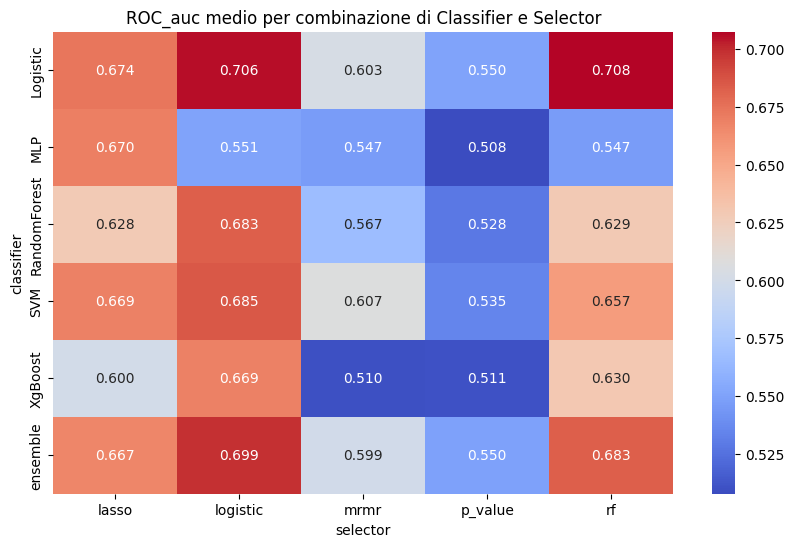

In [63]:

results_val_1=results_val_1_others+results_val_1_lasso
results_df = pd.DataFrame(results_val_1)

heatmap_data = results_df.pivot_table(index='classifier', columns='selector', values='roc_auc', aggfunc='mean')


plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('ROC_auc medio per combinazione di Classifier e Selector')
plt.show()

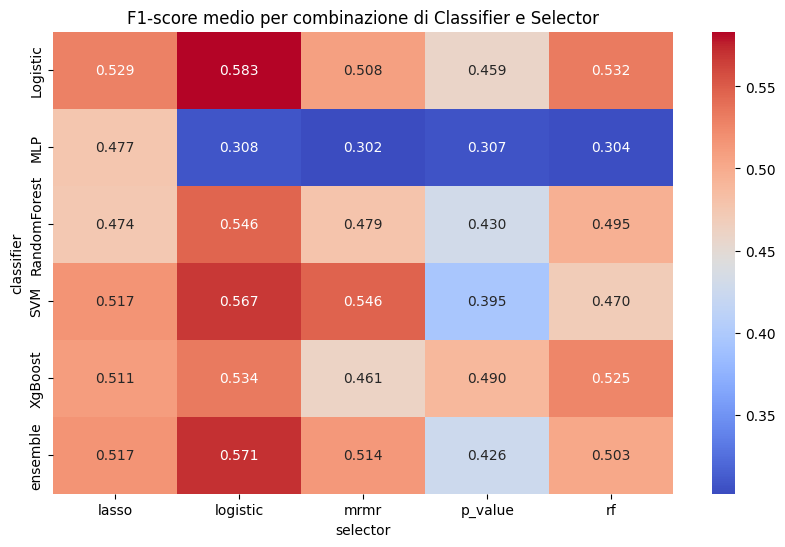

In [65]:
selectors=['lasso', 'rf', 'logistic', 'mrmr', 'p_value']
results_val_2=results_val_2_others+results_val_2_lasso
results_df = pd.DataFrame(results_val_2)

heatmap_data = results_df.pivot_table(index='classifier', columns='selector', values='f1', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True,
             cmap='coolwarm', fmt=".3f")
plt.title('F1-score medio per combinazione di Classifier e Selector')
plt.show()

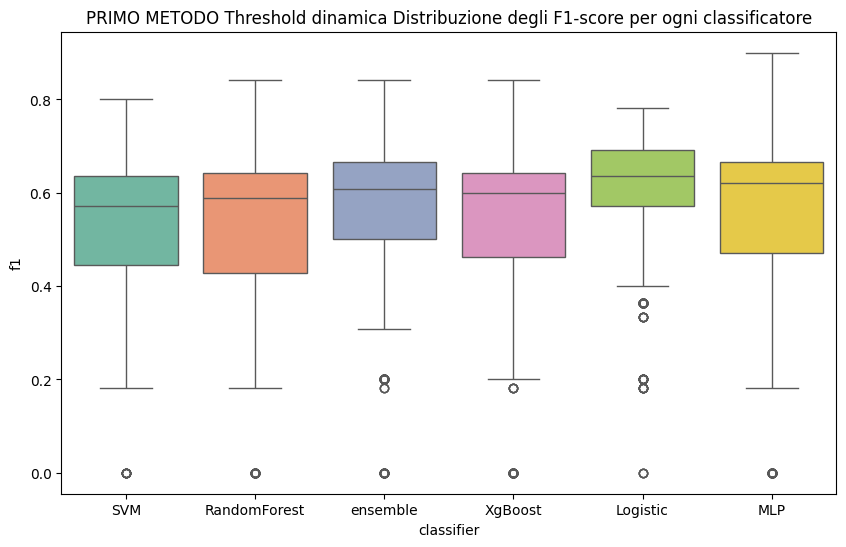

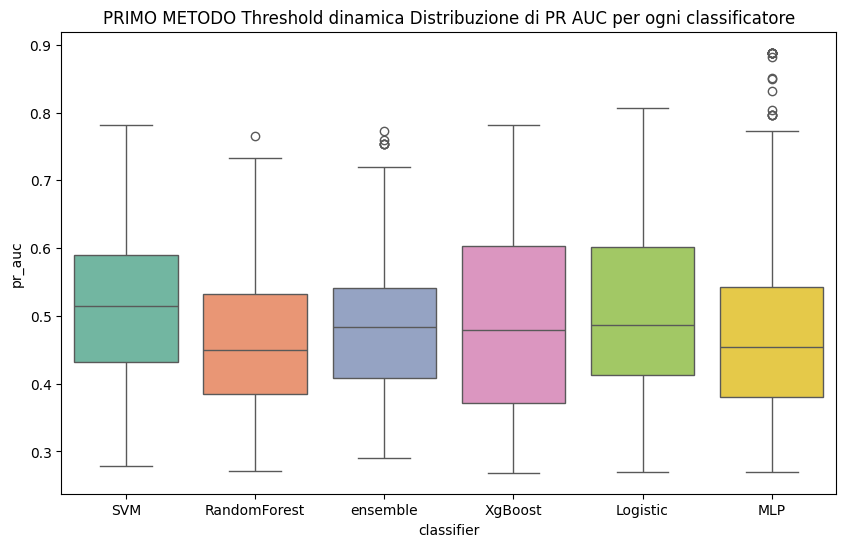

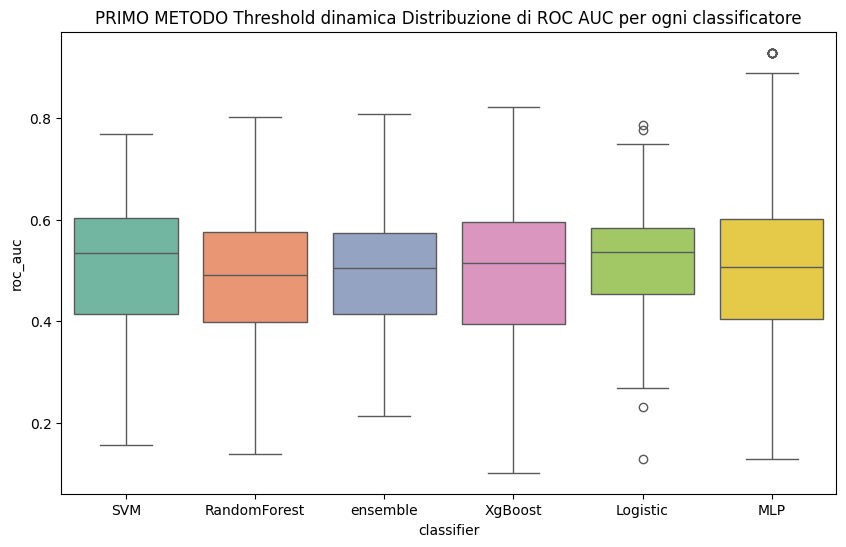

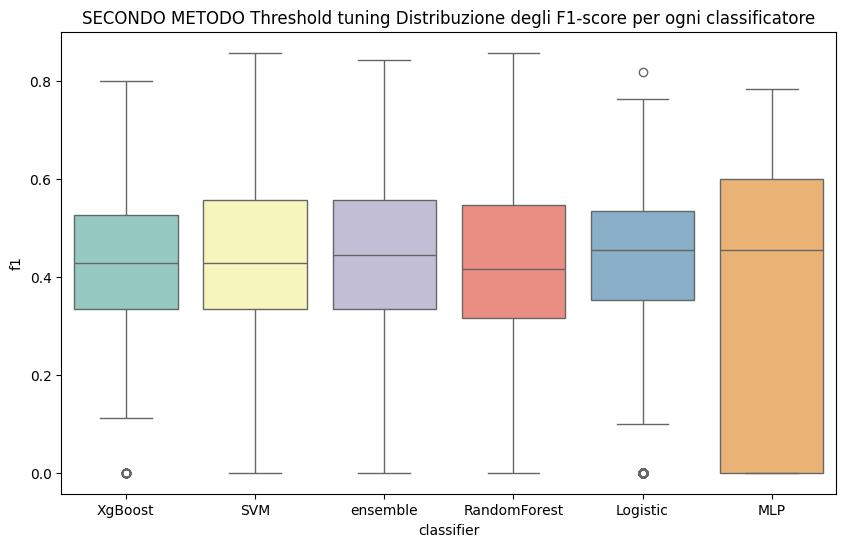

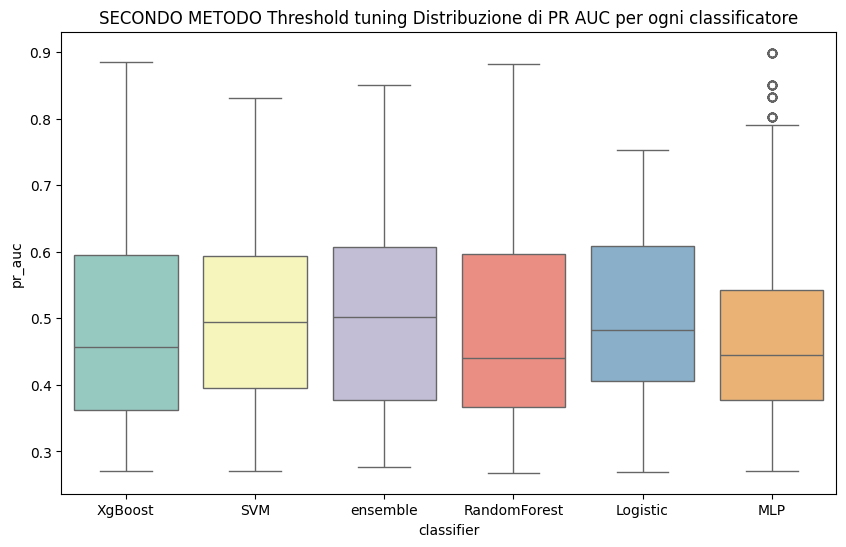

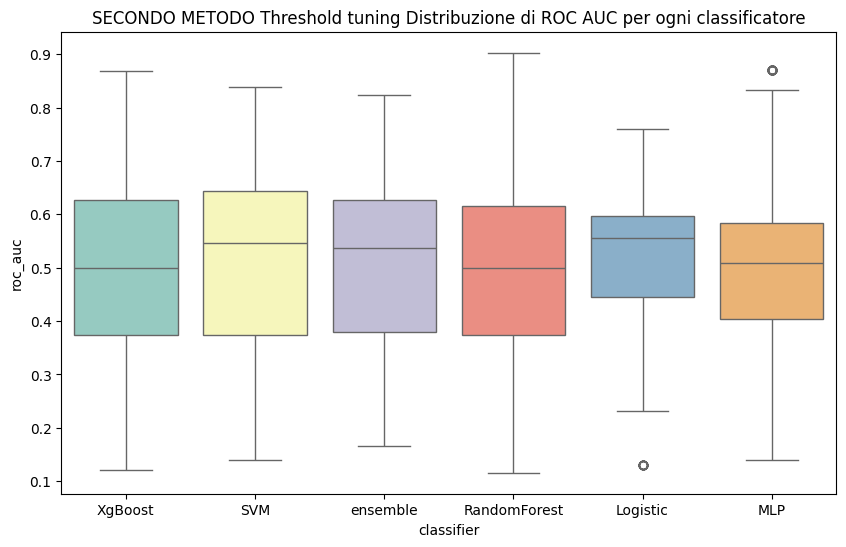

In [19]:

palette_primo_metodo = 'Set2'
palette_secondo_metodo = 'Set3'

results_df = pd.DataFrame(results_val_1)

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='f1', data=results_df, palette=palette_primo_metodo)
plt.title('PRIMO METODO Threshold dinamica Distribuzione degli F1-score per ogni classificatore')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='pr_auc', data=results_df, palette=palette_primo_metodo)
plt.title('PRIMO METODO Threshold dinamica Distribuzione di PR AUC per ogni classificatore')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='roc_auc', data=results_df, palette=palette_primo_metodo)
plt.title('PRIMO METODO Threshold dinamica Distribuzione di ROC AUC per ogni classificatore')
plt.show()

results_df = pd.DataFrame(results_val_2)

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='f1', data=results_df, palette=palette_secondo_metodo)
plt.title('SECONDO METODO Threshold tuning Distribuzione degli F1-score per ogni classificatore')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='pr_auc', data=results_df, palette=palette_secondo_metodo)
plt.title('SECONDO METODO Threshold tuning Distribuzione di PR AUC per ogni classificatore')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='roc_auc', data=results_df, palette=palette_secondo_metodo)
plt.title('SECONDO METODO Threshold tuning Distribuzione di ROC AUC per ogni classificatore')
plt.show()
